Epoch 1/100
----------
train Loss: 0.7769 Acc: 0.7935
val Loss: 0.2420 Acc: 0.9444
Epoch 2/100
----------
train Loss: 0.1218 Acc: 0.9676
val Loss: 0.2810 Acc: 0.9359
Epoch 3/100
----------
train Loss: 0.1631 Acc: 0.9622
val Loss: 0.2249 Acc: 0.9402
Epoch 4/100
----------
train Loss: 0.0861 Acc: 0.9741
val Loss: 0.2053 Acc: 0.9487
Epoch 5/100
----------
train Loss: 0.0654 Acc: 0.9827
val Loss: 0.2226 Acc: 0.9359
Epoch 6/100
----------
train Loss: 0.0331 Acc: 0.9914
val Loss: 0.1585 Acc: 0.9658
Epoch 7/100
----------
train Loss: 0.0243 Acc: 0.9935
val Loss: 0.0908 Acc: 0.9744
Epoch 8/100
----------
train Loss: 0.0089 Acc: 0.9989
val Loss: 0.0682 Acc: 0.9744
Epoch 9/100
----------
train Loss: 0.0109 Acc: 0.9978
val Loss: 0.0626 Acc: 0.9829
Epoch 10/100
----------
train Loss: 0.0049 Acc: 0.9989
val Loss: 0.0611 Acc: 0.9829
Epoch 11/100
----------
train Loss: 0.0059 Acc: 0.9978
val Loss: 0.0656 Acc: 0.9829
Epoch 12/100
----------
train Loss: 0.0034 Acc: 0.9989
val Loss: 0.0622 Acc: 0.9829
E

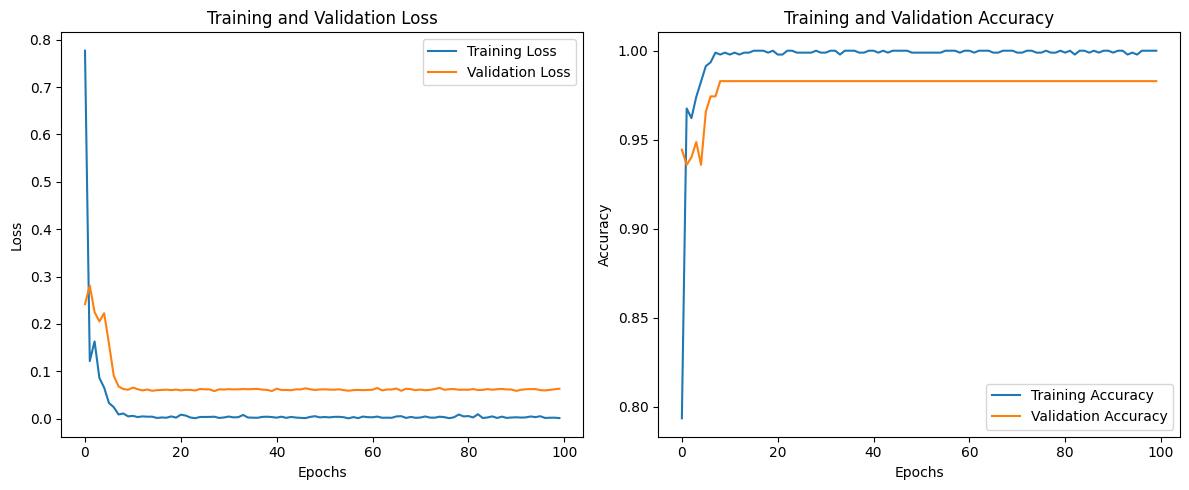

Validation Accuracy: 98.29%
Model saved as skin_disease_efficientnetB2_model.pth


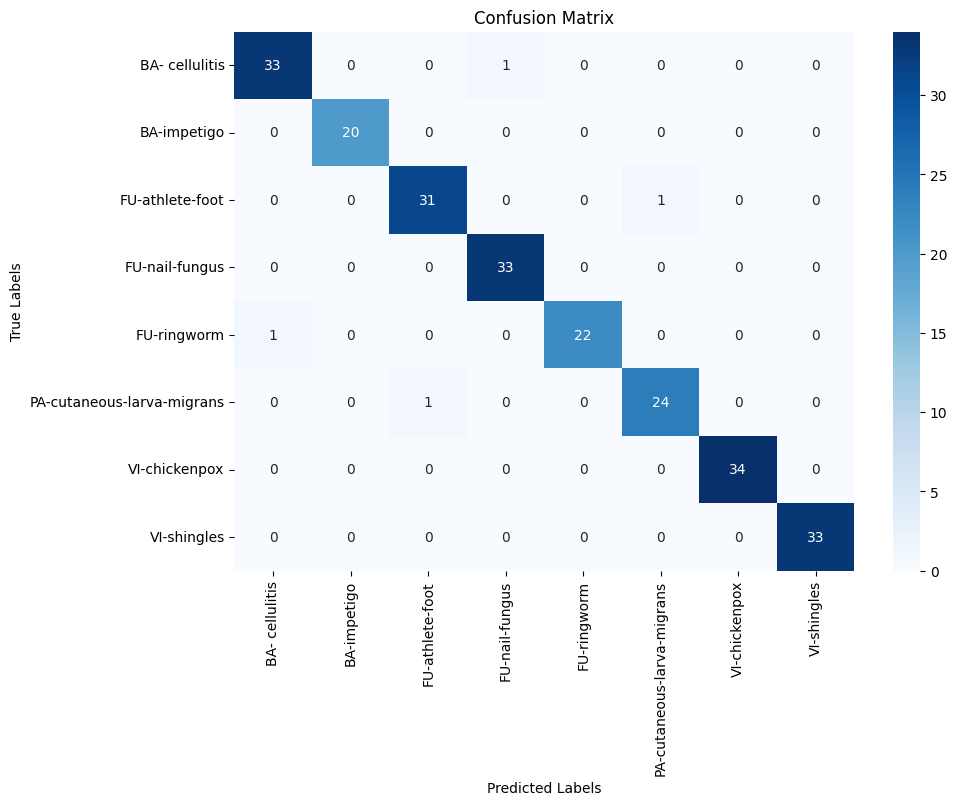

Classification Report:
                            precision    recall  f1-score   support

            BA- cellulitis       0.97      0.97      0.97        34
               BA-impetigo       1.00      1.00      1.00        20
           FU-athlete-foot       0.97      0.97      0.97        32
            FU-nail-fungus       0.97      1.00      0.99        33
               FU-ringworm       1.00      0.96      0.98        23
PA-cutaneous-larva-migrans       0.96      0.96      0.96        25
             VI-chickenpox       1.00      1.00      1.00        34
               VI-shingles       1.00      1.00      1.00        33

                  accuracy                           0.98       234
                 macro avg       0.98      0.98      0.98       234
              weighted avg       0.98      0.98      0.98       234



In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Define the paths to your dataset
train_path = r"C:\Users\Pravartak\OneDrive - IITM Pravartak Technologies Foundation\Desktop\minor_project\dataset\skin-disease-datasaet\train_set"
test_path = r"C:\Users\Pravartak\OneDrive - IITM Pravartak Technologies Foundation\Desktop\minor_project\dataset\skin-disease-datasaet\test_set"

# Check if the paths exist
if not os.path.exists(train_path):
    raise FileNotFoundError(f"Train directory not found: {train_path}")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"Test directory not found: {test_path}")

# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((260, 260)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((260, 260)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets
image_datasets = {
    'train': datasets.ImageFolder(train_path, data_transforms['train']),
    'val': datasets.ImageFolder(test_path, data_transforms['val'])
}
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=64, shuffle=False)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Load the EfficientNetB2 model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b2(weights="EfficientNet_B2_Weights.IMAGENET1K_V1")
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]).cpu().numpy()


            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                scheduler.step()

    return model, history

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=100)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Set model to evaluation mode
model.eval()

# Initialize counters for accuracy calculation
correct = 0
total = 0

# Turn off gradients for validation/testing
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Count correct predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate accuracy
accuracy = correct / total * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), 'skin_disease_efficientnetB2_model.pth')
print("Model saved as skin_disease_efficientnetB2_model.pth")

# Evaluate on test set and create confusion matrix
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)